We extract video frames from selected animations and extract
the line art images to form our training dataset. We calculate a
**768-dimensional feature vector of histograms of R, G, B channels
for each frame**. The difference between frames is determined by
calculating the **mean square error** of the feature vectors, which
is used for splitting the source animations into shots. When the
difference between the neighboring frames is **greater than 200**, it
is considered to belong to different shots. In order to improve the
quality of the data, we **remove shots in which the mean square
errors between all pairs of frames are less than 10** (as they are
too uniform), and **the shot with a length less than 8 frames**.
Then we **filter out video frames that are too dark or too faded
in color**. Finally we get a total of 
1096 video sequences from 6 animations, with a total of 29,834 images. 
Each video sequence
has 27 frames on average. 

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import json
import os
import shutil
import pandas as pd
from skimage.metrics import structural_similarity


Let's create the frames.

In [ ]:
def VidToFrames_2 (vidpath, folderName):
    vidcap = cv2.VideoCapture(vidpath)
    success,image = vidcap.read()
    count = 0
    length = int(vidcap.get(cv2.CAP_PROP_FPS))
    width  = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(length, width, height)
    while success:
        resized = cv2.resize(image, (256,256), interpolation = cv2.INTER_AREA)
        cv2.imwrite("{}/{}.png".format(folderName, str(count).zfill(5)), resized)  
        success,image = vidcap.read()
        count += 1
    print(count, "frames in file")

def VidToFrames (vidpath, folderName):
    vidcap = cv2.VideoCapture(vidpath)
    success,image = vidcap.read()
    print(success)
    count = 0
    length = int(vidcap.get(cv2.CAP_PROP_FPS))
    width  = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(length, width, height)
    while success:
        cv2.imwrite("{foldername}/{frameNum}.png".format(foldername= folderName, frameNum=str(count)), image)  
        success,image = vidcap.read()
        count += 1
    print(count, "frames in file")

# for i in glob.glob("mp4/*.mp4")[1:]:
#     print(i)
#     destination = i.split('.mp4')[0].split('-',1)[-1]
#     os.mkdir(destination)
#     VidToFrames_2(i, destination)

Now that we have folders with frames from each video for each channelId, we can start the analysis. There is two parts to this: 
1. Color analysis
2. Motion analysis

### Part I  <br/>
***Color Analysis*** <br/>
Is there a correlation between color and subcount?

In [ ]:
#XDoG
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
from pathlib import Path
import sys
from scipy.ndimage.filters import gaussian_filter
from torchvision import transforms
import cv2
import glob

def xdog(original, count, lineartPath, epsilon=0.5, phi=10, k=1.4, tau=1, sigma=0.5):
    image = cv2.imread(original, cv2.IMREAD_GRAYSCALE)
    image = gaussian_filter(image, 0.7)
    gauss1 = gaussian_filter(image, sigma)
    gauss2 = gaussian_filter(image, sigma*k)

    D = gauss1 - tau*gauss2

    U = D/255
    
    for i in range(0,len(U)):
        for j in range(0,len(U[0])):
            U[i][j] = abs(1-U[i][j])
    for i in range(0, len(U)):
        for j in range(0, len(U[0])):
            if U[i][j] >= epsilon:
                U[i][j] = 1
            else:
                ht = np.tanh(phi*(U[i][j] - epsilon))
                U[i][j] = 1 + ht

    lineart = U*255
    success = cv2.imwrite(lineartPath+"/%d.png" % count, lineart)

def dodgeV2(x, y):
    return cv2.divide(x, 255 - y, scale=256)

def xdog2 (original, lineartPath):
    img = cv2.imread(original)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_invert = cv2.bitwise_not(img_gray)
    img_smoothing = cv2.GaussianBlur(img_invert, (21, 21),sigmaX=0, sigmaY=0)
    final_img = dodgeV2(img_gray, img_smoothing)

    success = cv2.imwrite(lineartPath+original.split('/')[-1], final_img)     # save frame as JPEG file      

In [ ]:
def ColorToLineart (framepath):
    lineartpath = "lineart/"+ framepath.split('/')[-1]+"/"
    os.mkdir(lineartpath)
    print(lineartpath)
    imgList = glob.glob('%s/*'% framepath)
    count=0
    for i in imgList:
        try:
            xdog2(i, lineartpath)
            count+=1
        except:
            print(lineartpath)
    print(count, "out of", len(imgList), " files converted to lineart")
    

for framepath in glob.glob("frames/*/")[:1]:
    print(framepath)
    ColorToLineart(framepath)

In [3]:
def binAndPlot(some_list):
    sorted_list = sorted(some_list)
    sorted_counted = Counter(sorted_list)
    range_length = list(range(int(max(some_list)+1))) # Get the largest value to get the range.
    data_series = {}

    for i in range_length:
        data_series[i] = 0 # Initialize series so that we have a template and we just have to fill in the values.
    for key, value in sorted_counted.items():
        data_series[key] = value
    data_series = pd.Series(data_series)
    x_values = data_series.index
    plt.hist(some_list, edgecolor="yellow", color="green")
    plt.show()

### Part 2:
*** Motion Analysis ***

Is there a correlation between the amount of animation and subcount?

In my head, I should technically analyze how much each frame differs from each other. 
However, color is a value that is assigned to each pixel in a frame.

So we are going to get rid of color. We're not completely getting rid of it tho- any changes due to color will be detected (example)- because we are using
ahem ahem an eXtended difference-of-Gaussians to extract the lines. So we're basically changing the data to put less weight on color because it's already been accounted for in Part I.

 There was a time when I was interested in colorization machine learning techniques. Honestly, I still am, just less than this project. 

 There was a paper called [Deep Line Art Video Colorization with a Few References](https://arxiv.org/abs/2003.10685) that I spent some time generating data for. It was only after I generated all the data that I realized I don't have the resources (GPU, money, honestly, motivation was the biggest factor)

> We extract video frames from selected animations and extract
the line art images to form our training dataset. We calculate a
768-dimensional feature vector of histograms of R, G, B channels
for each frame. The difference between frames is determined by
calculating the mean square error of the feature vectors, which
is used for splitting the source animations into shots. When the
difference between the neighboring frames is greater than 200, it
is considered to belong to different shots. In order to improve the
quality of the data, we remove shots in which the mean square
errors between all pairs of frames are less than 10 (as they are
too uniform), and the shot with a length less than 8 frames.
Then we filter out video frames that are too dark or too faded
in color. Finally we get a total of 1096 video sequences from 6
animations, with a total of 29,834 images. Each video sequence
has 27 frames on average. 

In my case, I got around 28k iumages with 32 frames per scene on average.

I'm going to use the data collection method stated above, with a slight variation


In [4]:
with open('../channelId_to_mostViewedVidId.json', 'r') as j:
    channelId_to_mostViewedVidId = json.loads(j.read())

LIST_OF_CHANNEL_IDS= channelId_to_mostViewedVidId.keys()
print(len(LIST_OF_CHANNEL_IDS))
channelId_to_mostViewedVidId

62


{'UCsDmESjqNPukDmVnuneLrqw': 'EcgkRp2IUsc',
 'UCY6Ij8zOds0WJEeqCLOnqOQ': 'kbCah6yhYRs',
 'UClN24S5-fc7LD0JJW0FdGWw': 'ewsGmhAjjjI',
 'UC3iNdSV_RQU7DHTGpqEW96w': 'gA0bi-bFEYs',
 'UC_52i6mlrzOZs_NEuSepzAg': 'so1_5hYUEE8',
 'UCr3cBLTYmIK9kY0F_OdFWFQ': 'xa-4IAR_9Yw',
 'UCV6g95OBbVtFmN9uiJzkFqQ': 'I9uWUw1fxOY',
 'UCgCKYs56-LKEPGQ99DzqQOg': 'W8P5ewPk9fM',
 'UCOwxx9VnEnlFKt5EB70KTzQ': '12Ne9n40tmw',
 'UC2Ds30pkifFVD0CE08wF50g': 'Mv8OkBjySGQ',
 'UC7UGbBVrqLlq6CRxWWUmyKw': '2juKkLxdQo0',
 'UCn1XB-jvmd9fXMzhiA6IR0w': 'eNGgfPs0Xp8',
 'UCFeqAfEuKm7lIg2ddQzh61A': 'rlSXaDq3uOk',
 'UCAlxwHEm1bWWYoe5VCSQYEg': 'Vm6Yu2N-ePI',
 'UCz7iJPVTBGX6DNO1RNI2Fcg': '0Vxp_Lj2b-E',
 'UCOAUz4d1NUNxSHh_SOJtdGQ': '5pMckBGWzAY',
 'UCGGTAB19HlHEWPwwmxHsEKA': 'de8PRd_d7kg',
 'UCOsATJw-IZgqGT8MFrHjKGg': 'oKLbOxLJfRg',
 'UCsKVP_4zQ877TEiH_Ih5yDQ': 'Y7lYeRqhQ9Q',
 'UCOinp9hALPUcZeoL3Kmaviw': 'BErOLQBZ6c8',
 'UCGwu0nbY2wSkW8N-cghnLpA': 'plSyrHqUh78',
 'UCu6v4AdYxVH5fhfq9mi5llA': 'o0zjRGRYEhk',
 'UCj74rJ9Lgl3WTngq675wxKg': 'hp

In [5]:
with open('../masterSheetOfChannelIdToListOfVidInfos.json', 'r') as j:
    masterSheet = json.loads(j.read())

channelId_to_mostViewedVidInfo = {}

for channelId in LIST_OF_CHANNEL_IDS:
    mostViewedVidId = channelId_to_mostViewedVidId[channelId]
    for vidInfo in masterSheet[channelId]:
        if vidInfo['vidId'] == mostViewedVidId:
            channelId_to_mostViewedVidInfo[channelId] = vidInfo
channelId_to_mostViewedVidInfo
# print(len(channelId_to_mostViewedVidId))

{'UCsDmESjqNPukDmVnuneLrqw': {'vidId': 'EcgkRp2IUsc',
  'publishTime': '2017-10-26T01:05:22Z',
  'vidTitle': 'My Hot Babysitter Got Me In Trouble',
  'duration': 'PT6M30S',
  'viewCount': 35960829,
  'likeCount': 840561,
  'commentCount': 75550,
  'topicCategories': ['https://en.wikipedia.org/wiki/Entertainment',
   'https://en.wikipedia.org/wiki/Film'],
  'description': "First Name Babysitter. Last Name Trouble. \nGET T-SHIRTS: http://www.itsalexclark.com \nSEE ME ON TOUR: http://www.itsalexclark.com/tour\n\nThanks to Shgurr and PamonSunset:\nhttps://www.youtube.com/channel/UCkQ3eqNNaFrBZ_WbnCIMN8w\n\nSubscribe: http://bit.ly/SubAlexClark | Get ItsAlexClark merch: http://itsalexclark.bigcartel.com/ \nWatch my latest video: https://youtube.com/watch?v=YIiBGDBN-Po&list=PLmh1WGagp73Jbndkw6nCz2JCm73jEp8gh\nHelp out the channel: https://Patreon.com/itsalexclark\n\nFollow ItsAlexClark!\nFacebook: https://facebook.com/itsalexclark/?ref=br_rs\nInstagram: https://instagram.com/itsalexclark/\nT

In [7]:
import regex as re
channelId_to_mostViewedVidInfoDf = pd.DataFrame.from_dict(channelId_to_mostViewedVidInfo).T
not_candidate_vidIds= ['kQEtRoyFfI8', 'hpQQohcHk9Q', '6wS_uON5s6Q', 'RlU32AfEVeU', 'iVqhzEaJhDw', 'Xnv7JGqjaAo', '18msRdBF11A', 'Ln4AnsWNUQI', 'Hkz0NcKPzMs']

#https://en.wikipedia.org/wiki/ISO_8601#Durations
for channelId, row in channelId_to_mostViewedVidInfoDf.iterrows():
    x= row['duration']
    m=0
    s=0
    try:
        m, s = re.findall('PT(\d+)M(\d+)S',x)[0]
    except:
        s = re.findall('PT(\d+)S',x)[0]
    if int(m)*60+int(s) < 210:
        not_candidate_vidIds.append(row['vidId'])
not_candidate_vidIds = set(not_candidate_vidIds)
candidateVideos = list(set(channelId_to_mostViewedVidInfoDf.vidId)- not_candidate_vidIds)
channelId_to_mostViewedVidInfoDf = channelId_to_mostViewedVidInfoDf[channelId_to_mostViewedVidInfoDf.vidId.isin(candidateVideos)]
print(len(channelId_to_mostViewedVidInfoDf))
channelId_to_mostViewedVidInfoDf

43


,vidId,publishTime,vidTitle,duration,viewCount,likeCount,commentCount,topicCategories,description
UCsDmESjqNPukDmVnuneLrqw,EcgkRp2IUsc,2017-10-26T01:05:22Z,My Hot Babysitter Got Me In Trouble,PT6M30S,35960829,840561,75550,"[https://en.wikipedia.org/wiki/Entertainment, ...",First Name Babysitter. Last Name Trouble. \nGE...
UCY6Ij8zOds0WJEeqCLOnqOQ,kbCah6yhYRs,2019-06-11T11:00:07Z,Descendants doesn&#39;t make any sense...,PT16M8S,9850298,263259,22459,"[https://en.wikipedia.org/wiki/Entertainment, ...",Descendants doesn't make any sense animation\n...
UClN24S5-fc7LD0JJW0FdGWw,ewsGmhAjjjI,2018-10-09T20:50:50Z,I have APHANTASIA (and you may too...without r...,PT12M54S,6041764,320113,72063,"[https://en.wikipedia.org/wiki/Hobby, https://...",So...yeah. I'm an artist that can't see pictur...
UC3iNdSV_RQU7DHTGpqEW96w,gA0bi-bFEYs,2018-06-22T19:20:36Z,How KSI Saved Logan Paul&#39;s Career,PT6M48S,20326487,514050,95645,"[https://en.wikipedia.org/wiki/Entertainment, ...",This KSI vs Logan Paul fight is interesting to...
UC_52i6mlrzOZs_NEuSepzAg,so1_5hYUEE8,2017-09-20T22:12:54Z,Being a Boba Barista (Work Stories),PT5M20S,2196765,58187,3756,[https://en.wikipedia.org/wiki/Lifestyle_(soci...,Get it? “B”eing a “B”oba “B”arista “b”y “B”ill...
UCgCKYs56-LKEPGQ99DzqQOg,W8P5ewPk9fM,2019-01-18T20:00:06Z,Why I Dont Want a Hot Wife (Ft. Emirichu),PT8M7S,2319758,115467,5838,[https://en.wikipedia.org/wiki/Entertainment],"This week, we talk about one of the things I g..."
UC2Ds30pkifFVD0CE08wF50g,Mv8OkBjySGQ,2017-09-15T00:08:53Z,My Super HOT English Teacher (Animation),PT8M5S,9256911,303955,26316,"[https://en.wikipedia.org/wiki/Entertainment, ...","I have so many more stories, so subscribe and ..."
UC7UGbBVrqLlq6CRxWWUmyKw,2juKkLxdQo0,2019-05-11T17:14:40Z,"By the way, Are You a Sociopath?",PT11M23S,15162571,587421,45079,"[https://en.wikipedia.org/wiki/Entertainment, ...",Dragon City Sponsor link here: https://spons....
UCn1XB-jvmd9fXMzhiA6IR0w,eNGgfPs0Xp8,2016-09-26T21:49:18Z,Crushes,PT7M27S,31840209,912487,86962,"[https://en.wikipedia.org/wiki/Entertainment, ...",Get Crunchyroll Premium Ad Free for 30 Days: h...
UCFeqAfEuKm7lIg2ddQzh61A,rlSXaDq3uOk,2019-06-29T18:02:32Z,Childhood Crushes 2,PT17M16S,23048562,757408,83021,"[https://en.wikipedia.org/wiki/Entertainment, ...",Get Honey for FREE and start saving money toda...


Get lineart for all frames

couple that do not fit the criteria:: vidIds [kQEtRoyFfI8- gameplay, hpQQohcHk9Q- too short. not commentary, 6wS_uON5s6Q- speeddrawing, RlU32AfEVeU- footage apparently from another youtuber, iVqhzEaJhDw- too short, Xnv7JGqjaAo- speeddraw, iRBmUQQzpWQ- simply not animation, 18msRdBF11A- not animation, Ln4AnsWNUQI- not animation, Hkz0NcKPzMs- too short]



The plan is to find the distribution of DIFF. It'll vary based on the artist.

In [42]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from IPython.display import Image, display
import multiprocessing
import functools
from multiprocessing import Process

dictOfVidIdToDiffMse = {}

def getFeatureVectorOfImage_color (imagePath):
    image = cv2.imread(imagePath)
    vectors = []
    for i, col in enumerate(['b', 'g', 'r']):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        vectors.append(hist)
        # plt.plot(hist, color = col)
        # plt.xlim([0, 256])
    # plt.show()
    vectors = np.vstack(vectors)
    return vectors

def getFeatureVectorOfImage (imagePath):
    image = cv2.imread(imagePath)
    vectors = []
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    vectors = np.vstack(hist)
    return vectors

def MSE_images (f1_v, f2_v, listOfMSE): #small changes are even smaller, big changes are even bigger. 
    mse = np.sum(np.square(np.subtract(f1_v, f2_v)))
    listOfMSE.append(mse)
    return mse

def DIFF_images(f1_v, f2_v, listOfDIFF): #downside 3-1 vs 1-3 is the same. 
    listOfDIFF.append((np.abs(f1_v - f2_v)).mean())

def SSIM_images(image1, image2, listOfSSIM): #more structural. 
    (score, _) = structural_similarity(cv2.cvtColor(cv2.imread(image1), cv2.COLOR_BGR2GRAY), cv2.cvtColor(cv2.imread(image2), cv2.COLOR_BGR2GRAY), full=True)
    listOfSSIM.append(score)
    return score

def smap(f, *args):
    return f(*args)

def smap(f):
    return f()

def getMeanMedianStdVar(lst):
        return (np.amin(np.array(lst)),np.amax(np.array(lst)), np.mean(np.array(lst)), np.median(np.array(lst))), np.std(np.array(lst)), np.var(np.array(lst))
            
#https://ece.uwaterloo.ca/~z70wang/publications/ssim.pdf
def removeLowDiff_andDemo(folderName):
    vidId = folderName.split('/')[-1]
    print(">", folderName)
    frameList = glob.glob(folderName+'/*.png') #unfortunately, doesn't work bc sortByInt isn't a thing
    validFiles = 0 
    validFrameList = []

    lowRangeDone= False
    midRangeDone= False
    highRangeDone= False

    listOfMSE = []
    listOfDIFF = []
    listOfSIMM=[]

    imageShape = cv2.imread(frameList[0]).shape
    h,w,c = imageShape
    for i in range(len(frameList)-1):
        firstFrame = '{}/{}.png'.format(folderName, str(i).zfill(5))
        secondFrame = '{}/{}.png'.format(folderName, str(i+1).zfill(5))
        f1_v = getFeatureVectorOfImage_color(firstFrame)
        f2_v = getFeatureVectorOfImage_color(secondFrame)
        mse = MSE_images(f1_v, f2_v, listOfMSE)
        # DIFF_images(f1_v, f2_v, listOfDIFF)
        score = SSIM_images(firstFrame, secondFrame, listOfSIMM)

        if (score < 0.999):
            validFrameList.append(firstFrame)
            validFiles+=1
        # if (lowRangeDone and midRangeDone and highRangeDone) == False:
        #     if (score >= 0.9 and not lowRangeDone):
        #         print ("low diff = : ", score)
        #         print(firstFrame)
        #         display(Image(filename=firstFrame))
        #         print (secondFrame)
        #         display(Image(filename=secondFrame))
        #         lowRangeDone = True
        #     if (score > 0.6 and score < 0.9  and not midRangeDone):
        #         print ("mid diff = : ", score)
        #         print(firstFrame)
        #         display(Image(filename=firstFrame))
        #         print (secondFrame)
        #         display(Image(filename=secondFrame))
        #         midRangeDone = True
        #     if (score <= 0.6  and not highRangeDone):
        #         print ("high diff = : ", score)
        #         print(firstFrame) 
        #         display(Image(filename=firstFrame))
        #         print (secondFrame)
        #         display(Image(filename=secondFrame))
        #         highRangeDone = True
    # binAndPlot(listOfSIMM)

    dictOfVidIdToDiffMse[vidId] = {
    'validList': validFrameList, 'validityRatio': len(validFrameList)/len(frameList), 'ssim': getMeanMedianStdVar(listOfSIMM), 'mse': getMeanMedianStdVar(listOfMSE)
    }
    
for lineartPath in glob.glob("frames/*"):
    if lineartPath.split('/')[-1] not in not_candidate_vidIds:
        removeLowDiffDst = removeLowDiff_andDemo(lineartPath)

> frames/Mv8OkBjySGQ
> frames/2yFCyPX3kT0
> frames/OyDLuom4KGs
> frames/2juKkLxdQo0
> frames/uDvPIKM-L1o
> frames/2bGkEK8I6zQ
> frames/IwxWmKsVR5U
> frames/EcgkRp2IUsc
> frames/_uk_6vfqwTA
> frames/cZ_CnLE6SPo
> frames/Vm6Yu2N-ePI
> frames/gA0bi-bFEYs
> frames/O0hyjRF6quc
> frames/o0zjRGRYEhk
> frames/vv2vPAzj8S4
> frames/5pMckBGWzAY
> frames/n4CAhXpyVCI
> frames/0Vxp_Lj2b-E
> frames/nHgRnjqLmtM


In [ ]:
with open('vidIdToFramesListAndStats_mse_ssim.json', 'w') as output:
    json.dump(dictOfVidIdToDiffMse, output)
with open('vidIdToFramesListAndStats_mse_ssim.json') as input:
    data = json.load(input)
dictOfVidIdToDiffMse

In [9]:
vidIdToFramesListAndStatsDf = pd.DataFrame.from_dict(data).T


with open('../channelId_to_mostViewedVidId.json') as input:
    channelId_to_mostViewedVidId = json.load(input)
with open('../channelHolisticInfo.json') as input:
    channelHolisticInfo = pd.DataFrame.from_dict(json.load(input))

channelIdInOrder = []
for index in vidIdToFramesListAndStatsDf.index:
    for channelId, mostViewedVidId in channelId_to_mostViewedVidId.items():
        if index == mostViewedVidId:
            channelIdInOrder.append(channelId)

channelTitle=[]
channelSubCountNormalized=[]
for channelId in channelIdInOrder:
    for index, row in channelHolisticInfo.iterrows():
        if row['channelId'] == channelId:
            channelTitle.append(row['channelName'])
            channelSubCountNormalized.append(row['subscribersPerYearSinceFirstUpload'])
channelHolisticInfo.head()
vidIdToFramesListAndStatsDf['channelId'] = channelIdInOrder
vidIdToFramesListAndStatsDf['channelName'] = channelTitle
vidIdToFramesListAndStatsDf['subscribersPerYearSinceFirstUploadChannelName'] = channelSubCountNormalized
vidIdToFramesListAndStatsDf.head()

,diffMin,diffMax,diffMean,diffMedian,diffStd,diffVar,channelId,channelName,subscribersPerYearSinceFirstUploadChannelName
Mv8OkBjySGQ,0.0,512.0,13.803466,6.033854,39.45242,1556.4934,UC2Ds30pkifFVD0CE08wF50g,Daidus,2.892382e+05
2yFCyPX3kT0,0.0,493.17447,4.183102,0.0026041667,25.700415,660.5113,UCo8bcnLyZH8tBIH9V1mLgqQ,TheOdd1sOut,2.376871e+06
OyDLuom4KGs,0.0,512.0,8.465552,1.2916666,35.682846,1273.2654,UC2hm5rD_IrfYRMfq5YQudgA,Haminations,4.046380e+05
2juKkLxdQo0,0.0,511.15103,3.2010055,0.0,25.843119,667.86676,UC7UGbBVrqLlq6CRxWWUmyKw,DanPlan,2.756757e+05
uDvPIKM-L1o,0.0,512.0,10.913021,2.9166667,40.645348,1652.0444,UCP21EOiKAkCGjv6kqS6UsZw,LukeOrSomething,4.303323e+04


In [10]:
%matplotlib widget

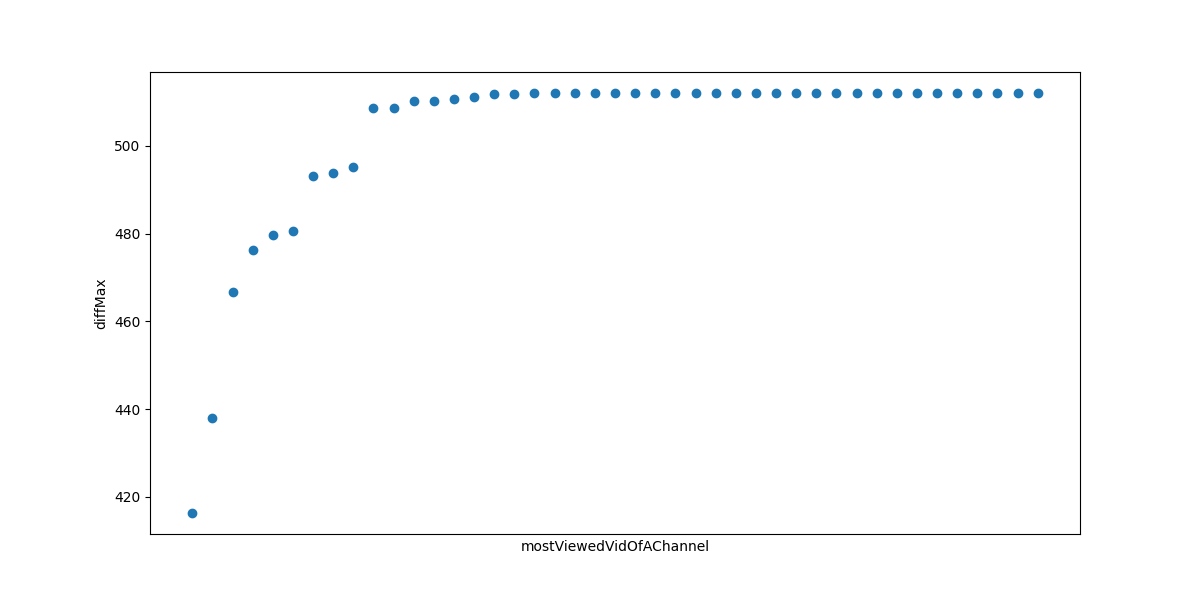

In [36]:
import mplcursors

x_name = "mostViewedVidOfAChannel"
y_name = "diffVar"
tooltip_name = "channel owner"
x = vidIdToFramesListAndStatsDf.index
y= [float(i) for i in vidIdToFramesListAndStatsDf[y_name]]

zipped = zip(x, y)
sorted_vidId_to_validRatio = dict(sorted(dict(zipped).items(), key=lambda item: item[1]))
# tt = df[tooltip_name]

fig, ax = plt.subplots(1, figsize=(12,6))
sc = ax.scatter(sorted_vidId_to_validRatio.keys(), sorted_vidId_to_validRatio.values())
# # Plot the average line
# avg_score= vidIdToFramesListAndStatsDf[y_name].mean()
# mean_x=np.arange(0,43,1)
# mean_y=[avg_score for i in np.zeros_like(x)]
# mean_line = ax.plot(mean_x,mean_y, label='Mean', linestyle='--')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
cursor = mplcursors.cursor(sc, hover=True)

plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()

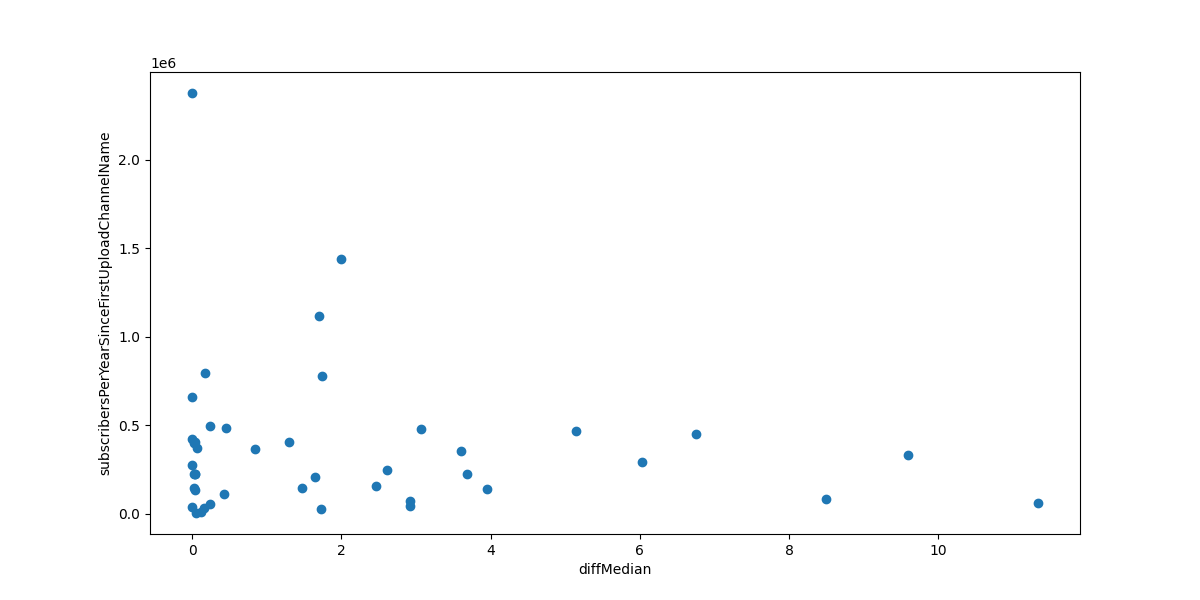

-0.1283134202052459


In [38]:
import numpy as np
import scipy.stats

def generate_plot(vidIdToFramesListAndStatsDf):
    x_name = "diffMedian"
    y_name = "subscribersPerYearSinceFirstUploadChannelName"
    tooltip_name = "channelName"
    x= [float(i) for i in vidIdToFramesListAndStatsDf[x_name]]
    y= [float(i) for i in vidIdToFramesListAndStatsDf[y_name]]

    tt = vidIdToFramesListAndStatsDf[tooltip_name]
    fig, ax = plt.subplots(1, figsize=(12,6))
    sc = ax.scatter(x, y)

    annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(details):
        pos = sc.get_offsets()[details["channelName"]]
        annot.xy = pos
        text = "{}, {}".format(" ".join(details["channelName"]), 
                            " ".join([details[x_name]]))
        annot.set_text(text)
        annot.get_bbox_patch().set_alpha(0.4)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, details = sc.contains(event)
            if cont:
                update_annot(details)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()
    cursor = mplcursors.cursor(sc, hover=True)
    cursor.connect(
    "add", lambda sel: sel.annotation.set_text(tt[sel.index]))
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()

    result = scipy.stats.linregress(x, y)
    m=result.slope
    b=result.intercept
    plt.plot([i for i in x], [m*i + b for i in x])
    print(result.rvalue)

generate_plot(vidIdToFramesListAndStatsDf)

In [ ]:
import numpy as np
import pandas as pd
def detect_outlier(data_1):
    outliers=[]
    # threshold=3 means any data with a stdDev> 3 or <-3 is 0.3 of all data. Almost all of the data (99.7%) should be within 3 stddev from the mean
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    index =0
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append((index, y))
        index+=1
    return outliers
x_name = "validityRatio"
y_name = "subscribersPerYearSinceFirstUploadChannelName"
x= vidIdToFramesListAndStatsDf[x_name].astype(float, errors = 'raise')
y= vidIdToFramesListAndStatsDf[y_name]
    
print("validityRatio outlier:", detect_outlier(x))
print("subs outlier:", detect_outlier(y))